##1. Initialization


*   Load CNN model
*   Load recipe and nutrition database







In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import csv
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
file_dir = "/content/drive/MyDrive/APS360 Project/"
model_path =  file_dir + "saved_model"
recipe_path = file_dir + "recipe_data.csv"
nutrition_path = file_dir + "nutrition_data.csv"

# 20 vegetable classes
vegetable_classes = ['asparagus', 'bell pepper', 'broccoli', 'cabbage', 'carrot', 'celery', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 
                     'lettuce', 'mushroom', 'onion', 'peas', 'potato', 'pumpkin', 'raddish', 'spinach', 'sweet potato', 'tomato']

In [ ]:
class VeggieCNN(nn.Module):
    def __init__(self):
        super(VeggieCNN, self).__init__()
        self.name = "VeggieCNN"
        self.conv1 = nn.Conv2d(256, 256, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 1 * 1, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc1(x)
        return x

In [ ]:
# import AlexNet
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 209MB/s]


In [ ]:
def alexnet_features(img):
  features = alexnet.features(img)
  features = torch.from_numpy(features.detach().numpy())
  features = features.squeeze(0)

  return features

In [ ]:
## load model
model = VeggieCNN().cuda()
state = torch.load(model_path)
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
## read recipe and nutrition csv files and load as numpy array 
with open(recipe_path,'r') as csvfile:
    data_reader = csv.reader(csvfile)

    recipe_data_orig = []
    for row in data_reader:
        recipe_data_orig.append(row)

with open(nutrition_path,'r') as csvfile:
    data_reader = csv.reader(csvfile)

    nutrition_data_orig = []
    for row in data_reader:
        nutrition_data_orig.append(row)

recipe_data_numpy = np.array(recipe_data_orig)
nutrition_data_numpy = np.array(nutrition_data_orig)

##2. Demonstration

In [ ]:
## user upload veggie images
from google.colab import files

num_veggie_img = input("How many vegetable images do you want to upload? ")
filename = []
veggie_imgs = []

for i in range(int(num_veggie_img)):
  uploaded = files.upload()
  filename = next(iter(uploaded))
  veggie_imgs.append(Image.open(filename))

How many vegetable images do you want to upload? 6


Saving 0-1.jpeg to 0-1 (1).jpeg


Saving 0-2.jpeg to 0-2.jpeg


Saving 0-4.jpeg to 0-4.jpeg


Saving 2-4.jpeg to 2-4.jpeg


Saving 6-4.jpeg to 6-4.jpeg


Saving IMG_5875.jpg to IMG_5875.jpg


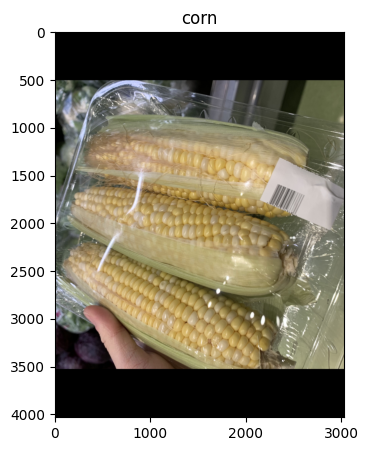

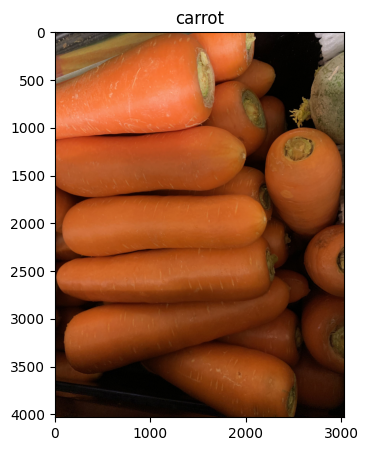

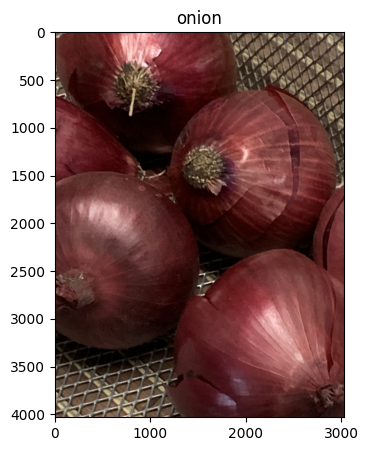

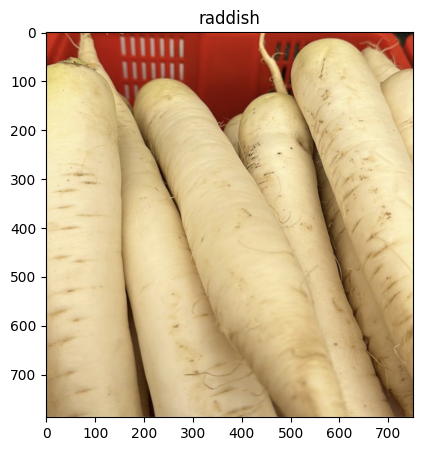

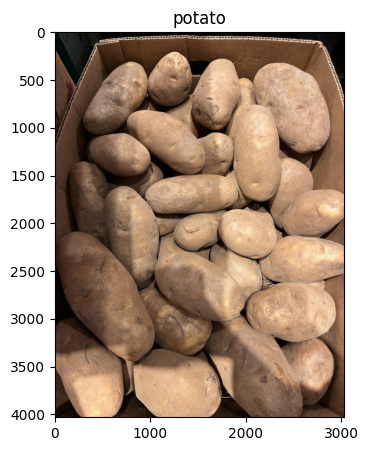

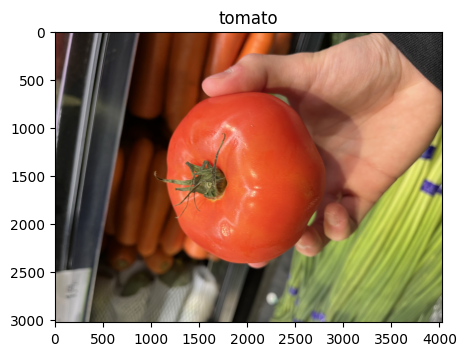

In [ ]:
## classify vegetables and display images with labels
veggie_labels = []
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Resize((224, 224))])

for img in veggie_imgs:
  #classification
  tensor_img = transform(img)
  veggie_features = alexnet_features(tensor_img).cuda()
  output = model(veggie_features)
  pred = output.max(1, keepdim=True)[1]

  #store and display results
  label = vegetable_classes[pred]
  veggie_labels.append(label)
  plt.figure(figsize=(5,5))
  plt.imshow(img)
  plt.title("{}".format(label))
  plt.show()

In [ ]:
import re

description = input("Please give a short description of what you are looking for in your recipe: ")
description_array = re.findall(r'\w+', description)
print(f"user's description of desired recipe input string: {description_array}\n")

Please give a short description of what you are looking for in your recipe: I want something spicy with chicken seasoned with black pepper or chili powder!
user's description of desired recipe input string: ['I', 'want', 'something', 'spicy', 'with', 'chicken', 'seasoned', 'with', 'black', 'pepper', 'or', 'chili', 'powder']



In [ ]:
class_scores = {0:0}

i = 0
for entry in recipe_data_numpy:
  if i == 0:
    i = i + 1
    continue
  veggies_array = entry[1].split("\n")
  keywords_array = entry[2].split("\n")

  # compute class scores - weight is 3x that of keywords
  current_class_score = 0
  for item in veggies_array:
    if item in veggie_labels:
      current_class_score = current_class_score + 3
  for word in description_array:
    if word in keywords_array:
      current_class_score = current_class_score + 1
  class_scores[i] = current_class_score
  i = i + 1

print(f"vegetable labels computed by the CNN model: {veggie_labels}\n")
print(class_scores)

vegetable labels computed by the CNN model: ['corn', 'carrot', 'onion', 'raddish', 'potato', 'tomato']

{0: 0, 1: 4, 2: 3, 3: 5, 4: 6, 5: 5, 6: 5, 7: 0, 8: 5, 9: 11, 10: 6, 11: 8, 12: 9, 13: 9, 14: 8, 15: 4, 16: 6, 17: 7, 18: 14, 19: 2, 20: 12, 21: 3, 22: 3, 23: 7, 24: 6, 25: 4, 26: 7, 27: 2, 28: 3, 29: 13, 30: 8, 31: 4, 32: 5, 33: 11, 34: 3, 35: 6, 36: 6, 37: 9, 38: 3, 39: 6, 40: 3, 41: 1, 42: 8, 43: 1, 44: 7, 45: 3, 46: 5, 47: 0, 48: 3, 49: 9, 50: 1, 51: 9, 52: 4, 53: 2, 54: 10, 55: 4, 56: 9, 57: 5, 58: 3, 59: 3, 60: 5, 61: 4, 62: 7, 63: 7, 64: 7, 65: 3, 66: 10, 67: 7, 68: 3, 69: 10, 70: 7, 71: 0, 72: 3, 73: 3, 74: 8, 75: 7, 76: 6, 77: 6, 78: 1, 79: 14, 80: 11, 81: 0, 82: 7, 83: 6, 84: 7, 85: 3, 86: 6, 87: 1, 88: 8, 89: 4, 90: 6, 91: 8, 92: 7, 93: 3, 94: 8, 95: 3, 96: 3, 97: 7, 98: 1, 99: 9, 100: 9, 101: 8, 102: 9, 103: 5, 104: 6, 105: 5, 106: 3, 107: 1, 108: 5, 109: 4, 110: 5, 111: 4, 112: 11, 113: 4, 114: 3, 115: 5, 116: 8, 117: 7, 118: 14, 119: 8, 120: 6, 121: 5, 122: 6, 123: 11, 

In [ ]:
import re
from prettytable import PrettyTable

sorted_dict = dict(sorted(class_scores.items(), key=lambda item: item[1], reverse=True))

top_three = list(sorted_dict.items())[:3]
print("\nHere are the top 3 recipe entries that best matched your given input!\n")
i = 1
for key, value in top_three:
  print(f"#{i}: {recipe_data_numpy[key][0]}\n")
  
  print(f"Ingredients: \n")
  delimiters = ["['", "', '", "']"]
  pattern = '|'.join(map(re.escape, delimiters))
  ingredients_array = re.split(pattern, recipe_data_numpy[key][3])
  ingredients_array = [element for element in ingredients_array if element != '']
  for ingredient in ingredients_array:
    print(f"• {ingredient}")

  print("\n")
  print(f"Instructions: \n")
  instructions_array = recipe_data_numpy[key][4].split("\n")
  instructions_array = [element for element in instructions_array if element != '']
  for instruction in instructions_array:
      print(f"• {instruction}")

  print("\n")
  print("Nutritional data of vegetables found in our nutrition database (values are per 100 g): \n")
  table = PrettyTable(['Vegetable Name', 'Energy', 'Carbonhydrates', 'Fat', 'Protein', 'Vitamins', 'Minerals', 'Other constituents'])
  for veggie in veggie_labels:
    for entry in nutrition_data_numpy:
      if veggie in entry and veggie in recipe_data_numpy[key][1]:
        table.add_row([entry[0], entry[1], entry[2], entry[3], entry[4], entry[5]+"\n", entry[6], entry[7]])
  print(table)

  print("\n\n")
  # print(f"photo: {recipe_data_numpy[key][5]}\n\n")
  i = i + 1



Here are the top 3 recipe entries that best matched your given input!

#1: Rogan Josh, Lamb Shanks

Ingredients: 

• 2/3 cup sour cream 
• 1 tablespoon all-purpose flour 
• 1/2 teaspoon chili powder 
• 1 teaspoon ground coriander 
• 1/2 teaspoon ground ginger 
• 2 cubes chicken bouillon 
• 4 whole cardamom pods, broken 
• 1 (14.5 ounce) can diced tomatoes 
• 1 cup water 
• ground nutmeg to taste 
• salt and ground black pepper to taste 
• 2 tablespoons cornstarch 
• 1/4 cup water 
• 1 large onion, cut into wedges 
• 3 lamb shanks 
• 1 (15 ounce) can carrots, drained 
• 1 (15 ounce) can whole new potatoes, drained 
• 1/2 pound button mushrooms, quartered (optional) 


Instructions: 

• Stir the sour cream and all-purpose flour together in a small bowl until smooth and set aside. In a separate small bowl, mix together the cornstarch and water to make a paste.
• Combine the chili powder, coriander, ginger, bouillon cubes, cardamom, tomatoes, water, nutmeg, salt and pepper in a medium sau